# Style Transfer Tutorial 



# Our Changes:

We have modified this code to get input form the user for various parameters which are as follows

1. Content Weight: Weight for the content-loss-function.
2. Style Weight: Weight for the style-loss-function.
3. Denoise Weight: Weight for the denoising-loss-function.
4. Num Iterations: Number of optimization iterations to perform.
5. Step Size: Step-size for the gradient in each iteration.

On click of the 'Set Vaues' button, the values are loaded into python code by javascript and the style_transfer algorithm is run.


# Introduction

This tutorial is based on the code written by <b>Magnus Erik Hvass Pedersen</b> for style transfer. The style transfer algorithm uses the same idea as the deepdream algorithm.

### Input
This algorithm takes two images as input: 
1. Content-image 
2. Style-image. 

### Output
The Algorithm generates a mixed-image as output image which has the margins of the content-image and the texture and colors (Style) of the style-image.


## Algorithm

The main aim of this algorithm is to generate a mixed image from two input images (content images and style images). The mixed image shows takes the contours of the content image and the style of the style image. For this algorithm we are going to use the the vgg16 pre trained neural network model. The vgg16 is a complex model which has many layers and is easily imported in the tensorflow.

The way the algorithm works is the content image is passed through one or more layers of the vgg16 model. The content loss is calculated between the layer values and the values when the content image is passed as the input, this is called as the content loss. While generating the content-loss for the input image with respect to the layer a node is added to the tensor flow graph which is excuted each time another input is passed(mixed image) to the model which calculates the content-loss then between the values of the layer when the content image is passed and the values of layer when the mixed image is passed. The main aim of the content-loss is to minimixe the activation features for the content image and the mixed image. This will result in the features of the mixed images being applied to the mixed image.

Similarly the style image is passed through one or more layers of the vgg16 model, the style loss is calculated between the gram matrix of the layers and the layer values when the style image is passed through the layers, this is called as the style loss. While genetrating the style loss a layer is added to the tensorflow graph which is excuted eachtime when another input image(mixed image) is passed as input and calculates the loss between the value of the gram matrix of the layer when the style image was passed and the values of the layer when the mixed image is passed. The main aim of the style loss is to minimize the difference between the gram matrices for the style image and the mixed image.



We use TensorFlow to automatically derive the gradient for these loss-functions. The gradient is then used to update the mixed-image. This procedure is repeated a number of times until we are satisfied with the resulting image.

There are some details of the Style Transfer algorithm not shown in this flowchart, e.g. regarding calculation of the Gram-matrices, calculation and storage of intermediate values for efficiency, a loss-function for denoising the mixed-image, and normalization of the loss-functions so they are easier to scale relative to each other.

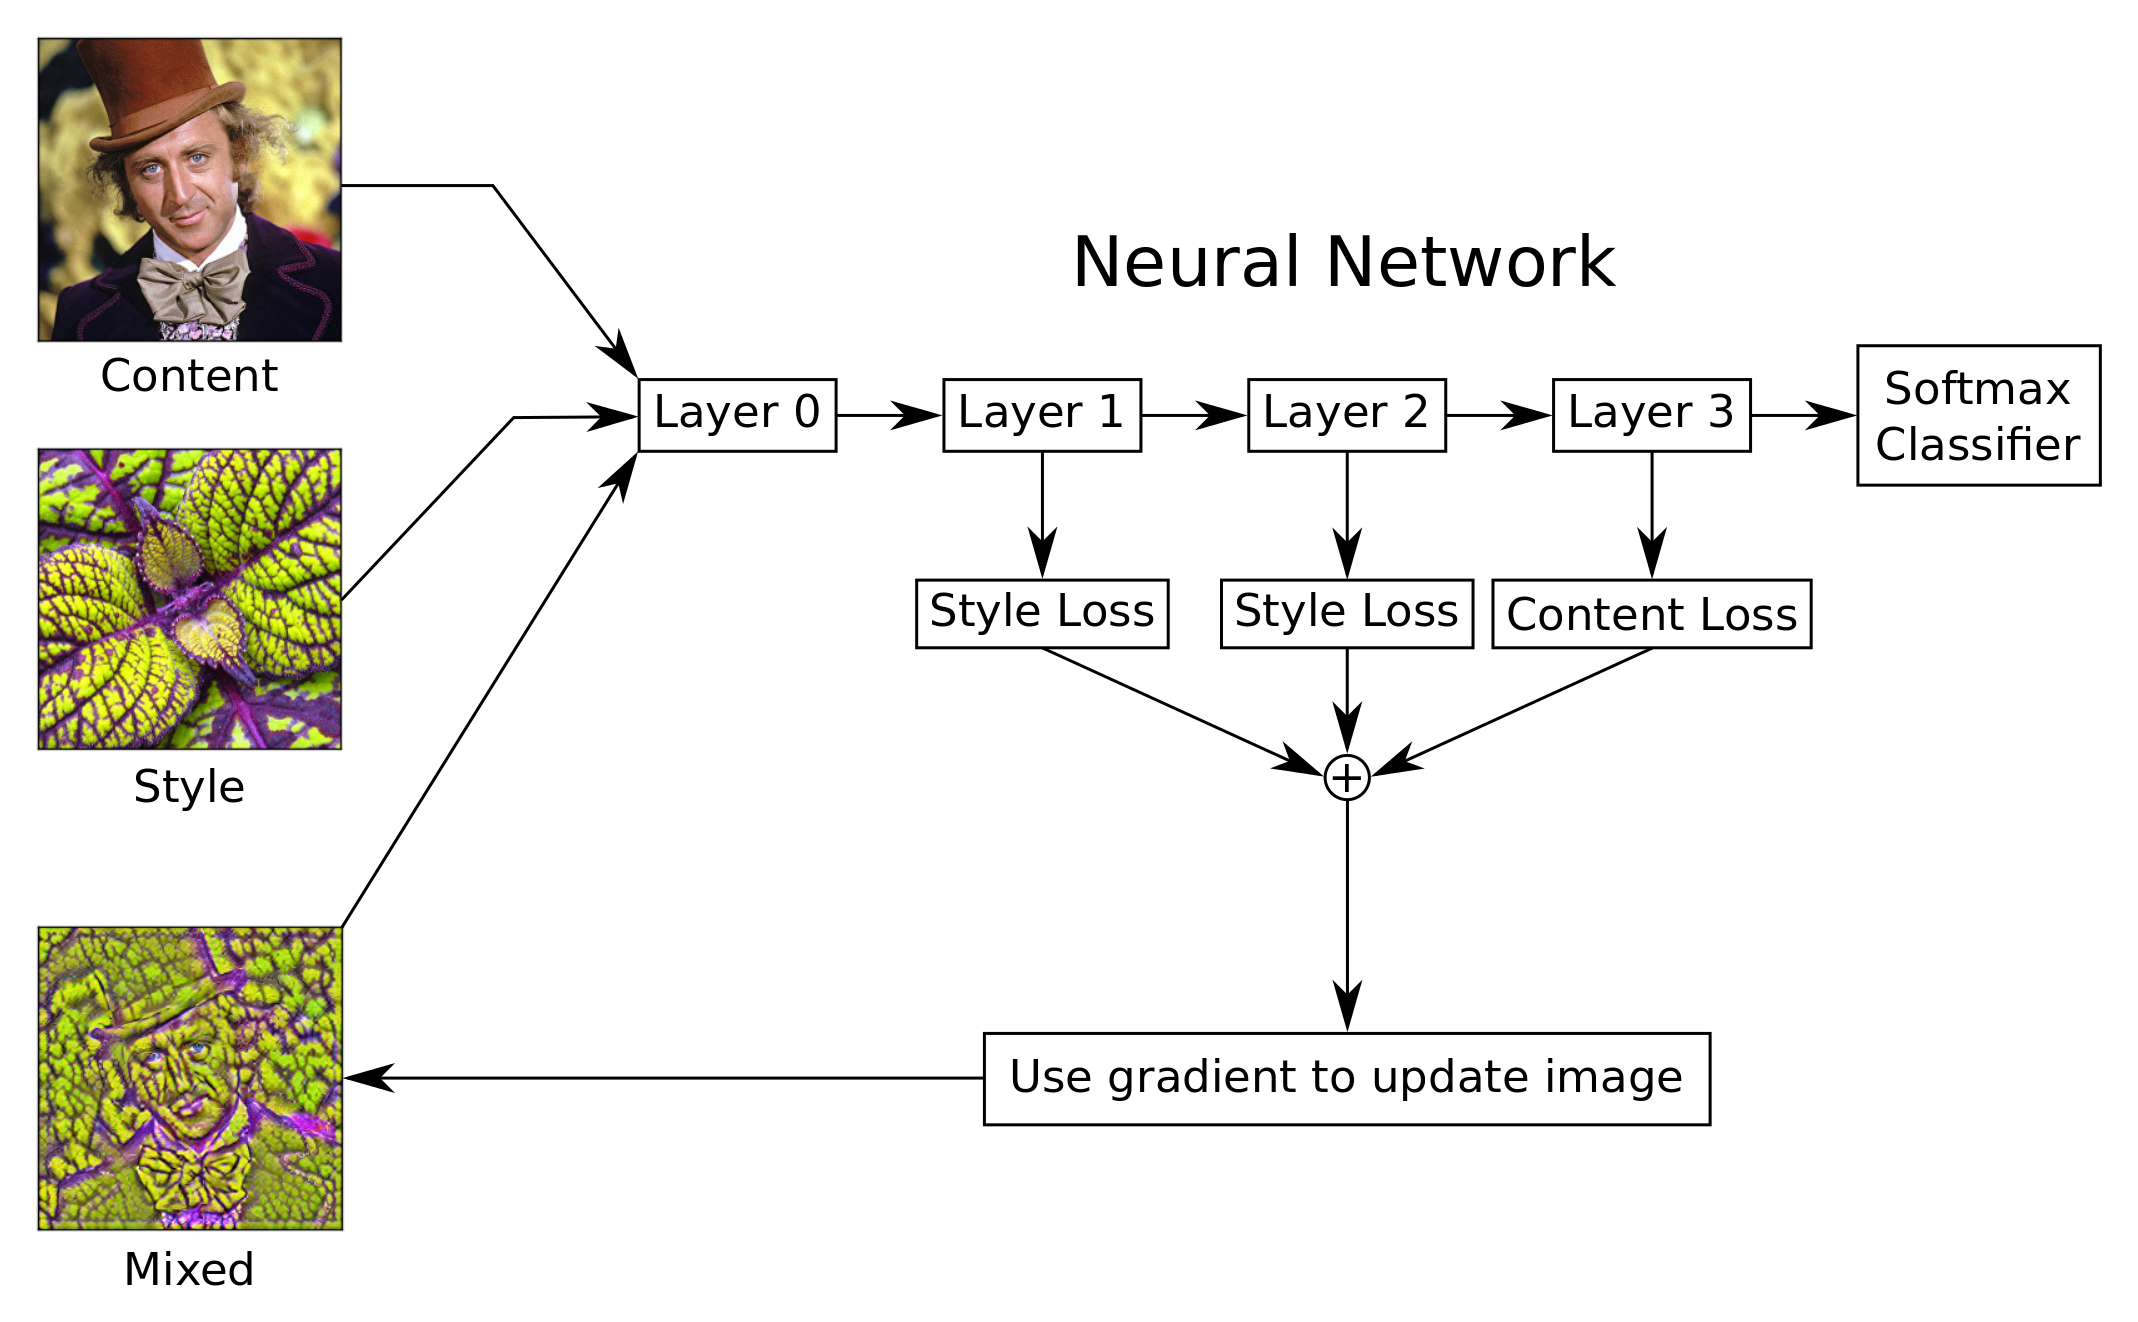

In [1]:
from IPython.display import Image, display
Image('images/15_style_transfer_flowchart.png')

## Import The Following Python Packages 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'0.12.1'

## VGG-16 Model

For the tutorial we will use the pretrained vgg16 model which can be easily loaded in tensorflow. This model differs from the vgg19 model. Below line imports the vgg16 model.

In [4]:
import vgg16

The vgg16 model has to be downloaded online. Below line gives the data directory to download the vgg16 model.

In [5]:
# vgg16.data_dir = 'vgg16/'

We call the maybe_download() method to download the vgg16 model

In [6]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## Functions to Manipulate Images


This function load_image loads an image and returns it as a numpy array of floating-points. The image can be automatically resized so the largest of the height or width equals `max_size`. The function takes filename and the max_size as arguments. max_size is an optional argument which is default to none.

In [7]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    print('Load Image excuting......')
    print('Image Size:',image.size)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        maxImgSize=np.max(image.size)
        print('maximum Image Size:',maxImgSize)
        factor = max_size / np.max(image.size)
        print('factor:',factor)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor
        print(size)

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)
        print('Image Tensor:',image)

    # Convert to numpy floating-point array.
    return np.float32(image)

The function save_image saves an image as a jpeg-file. The image is given as a numpy array with pixel-values between 0 and 255. This function takes the image and the file path as arguments.

In [8]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255. IIt will clip the values between 0 and 255
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format and save it 
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

This function plot_image_big plots a large image. The image is given as a numpy array with pixel-values between 0 and 255. The funcation takes the image to be plot as argument.

The function plot_image plots the content-image, mixed-image and style-image.

In [9]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [10]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Loss Functions Calculations

This algorithm needs content-loss, style-loss and denoise-loss. These helper-functions create the loss-functions that are used in optimization with TensorFlow. 

This function mean_squared_error creates a TensorFlow operation for calculating the Mean Squared Error between the two input tensors.

In [11]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

This function creates the loss-function for the content-image. This is done by feeding the content image through the layers chosen for content activation. The mean squared loss is calculated between the layer values and the value of the layer when the content image is passed. A node is added to the tensor flow graph for future inputs(when the mixed image is passed as the input) which then will calculate the loss between the layer values when the content image is passed as input and the layer values when the mixed image is passed as input. 

This content loss is then minimized, it therefore means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers you select, this should transfer the margins from the content-image to the mixed-image.


In [12]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    print("Running Content Loss...",layer_ids)
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)
    print('layers are:',layers)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)
            
        
            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)
           
            

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
   
    return total_loss

We want to produce a similar activation for style content of the style image and the conternt image. One of the ways to do this is to calculate the gram matrix for each of the style layers. The gram matrix is a matrix dot product of the feature chanels of the layer with the transpose of the feature activations of the style layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

This is the helper-function for calculating the Gram-matrix of a tensor output by a convolutional layer in the neural network. 

In [13]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram                            

The following function creates the content loss of the by finding the mean square error between the gram matrix calculated for the layer and the value of the tensor when the style image is passed through the model.


In [14]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
                
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called [Total Variation Denoising](https://en.wikipedia.org/wiki/Total_variation_denoising) and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [15]:
def create_denoise_loss(model):
    
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Style-Transfer Algorithm

This is the main optimization algorithm for the Style-Transfer algorithm. It is basically just gradient descent on the loss-functions defined above.

This algorithm also uses normalization of the loss-functions. This appears to be a novel idea not previously published. In each iteration of the optimization, the loss-values are adjusted so each of them equals one. This allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

In [16]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()
    print(model.input)

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)
    #tf.print(loss_content)
    
    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            #Saving the mixed image after every 10 iterations 
            filename='images/outputs_StyleTransfer/Mixed_Iteration' + str(i) +'.jpg'
            print(filename)
            save_image(mixed_image, filename)
            print()
            
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## Example

This example shows how to transfer the style of various images onto a portrait.

First we load the content-image which has the overall contours that we want in the mixed-image.

In [18]:
content_filename = 'images/willy_wonka_new.jpg'
content_image = load_image(content_filename, max_size=None)

filenamestyle='images/outputs_StyleTransfer/Content.jpg'
print(filenamestyle)
save_image(content_image, filenamestyle)

Load Image excuting......
Image Size: (299, 299)
images/outputs_StyleTransfer/Content.jpg


Then we load the style-image which has the colours and textures we want in the mixed-image.

In [19]:
style_filename = 'images/style7.jpg'
style_image = load_image(style_filename, max_size=300)

filenamestyle='images/outputs_StyleTransfer/Style.jpg'
print(filenamestyle)
save_image(style_image, filenamestyle)

Load Image excuting......
Image Size: (361, 359)
maximum Image Size: 361
factor: 0.831024930748
[ 300.          298.33795014]
Image Tensor: <PIL.Image.Image image mode=RGB size=300x298 at 0x95F68DE48>
images/outputs_StyleTransfer/Style.jpg


Then we define a list of integers which identify the layers in the neural network that we want to use for matching the content-image. These are indices into the layers in the neural network. For the VGG16 model, the 5th layer (index 4) seems to work well as the sole content-layer.

In [20]:
content_layer_ids = [6]

Then we define another list of integers for the style-layers.

In [21]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

## Code Added For Taking User Input:

This section is added to allow the user to enter input values for various parammeters which are as follows:
1.   Content Weight: Weight for the content-loss-function.
2.   Style Weight: Weight for the style-loss-function.
3.   Denoise Weight: Weight for the denoising-loss-function.
4.   Num Iterations: Number of optimization iterations to perform.
5.   Step Size: Step-size for the gradient in each iteration.

On click of the 'Set Vaues' button, the values are loaded into python code by javascript and the style_transfer algorithm is run.

The Content Weight, Style Weight, Denoise Weight are normalized. So the user can enter the content weight, style weight and the 
Denoise weight relative to eachother.

#### Content Weight, Style Weight, Denoise Weight and Step Size are foat values
#### Number of Iterations is an integer value




In [22]:
from IPython.display import HTML

#Code for Html labels and textboxes.
# There are 5 labels and 5 corresponding textboxes.

input_form = """
<div>
Weight Content: <input type="text" id="weightContenti"><br>
weight Style: <input type="text" id="weightStylei"><br>
Weight Denoise: <input type="text" id="weightDenoisei"><br>
Number Of Iterations: <input type="text" id="noOfIterationsi"><br>
Step Size: <input type="text" id="stepSizei"><br>
<input type="submit" value="Set Values" onclick="setValues()">

</div>
"""

# JavaScript code to get the values of each text box on the click of submit button. The values of each textbox is retrieved 
# and assigned to a javascript variable. This value is assigned to a variable. A  separate command is created for assigning 
# the inputs values to a varibale. An Ipython notebook kernel object is created and each coman is excuted to access the variable 
# containing the users input values in python code.

javascript = """
<script type="text/Javascript">
    function setValues(){
        var weightContent='weightContent';
        var weightStyle='weightStyle';
        var weightDenoise='weightDenoise';
        var noOfIterations='noOfIterations';
        var stepSize='stepSize';
        var weightContentValue = document.getElementById('weightContenti').value;      
        var weightStyleValue = document.getElementById('weightStylei').value;
        var weightDenoiseValue =  document.getElementById('weightDenoisei').value;
        var noOfIterationsValue = document.getElementById('noOfIterationsi').value;
        var stepSizeValue = document.getElementById('stepSizei').value;
        console.log(weightContentValue);
        console.log(weightStyleValue);
        console.log(weightDenoiseValue);
        console.log(noOfIterationsValue);
        console.log(stepSizeValue);
    
        var command = weightContent +" = '" + weightContentValue + "'"
        var command1= weightStyle +" = '" + weightStyleValue + "'"
        var command2 = weightDenoise +" ='" + weightDenoiseValue + "'"
        var command3 = noOfIterations +" ='" + noOfIterationsValue + "'"
        var command4 = stepSize +" ='" + stepSizeValue + "'"
        
        //console.log("Executing Command: " + command1);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        kernel.execute(command1);
        kernel.execute(command2);
        kernel.execute(command3);
        kernel.execute(command4);
    }
</script>
"""
HTML(input_form + javascript)


Now perform the style-transfer. 
Before calling the style_transfer function. Code is written to vaildate the users inputs. If the user has not given any 
input, then a default value is passed to the function. Also the user inputs are retrieved in string format. These inputs are converted into proper data type before passing them to the style_transfer function. 

The style transfer function
automatically creates the appropriate loss-functions for the style- and content-layers, and 
then performs a number of optimization iterations. This will gradually create a mixed-image which has similar contours as the content-image, with the colours and textures being similar to the style-image.


This can be very slow on a CPU!

Weight Content 10.0
Weight Style 1.5
Weight Denoise 0.3
No of Iterations: 20
Step Size: 10.0
Tensor("images:0", dtype=float32)
Content layers:
['conv3_3/conv3_3']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

Running Content Loss... [6]
layers are: [<tf.Tensor 'conv3_3/conv3_3:0' shape=(?, ?, ?, 256) dtype=float32>]
. 
Iteration: 0
Weight Adj. for Content: 4.94e-11, Style: 2.14e-29, Denoise: 5.62e-06


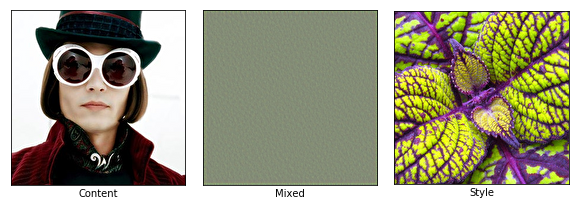

images/outputs_StyleTransfer/Mixed_Iteration0.jpg

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 8.78e-11, Style: 3.43e-29, Denoise: 1.55e-07


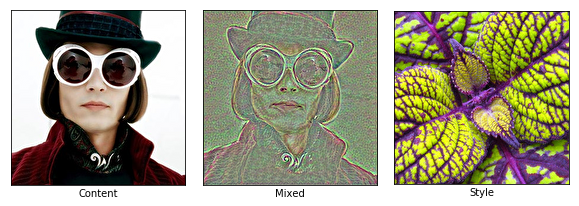

images/outputs_StyleTransfer/Mixed_Iteration10.jpg

. . . . . . . . . 
Iteration: 19
Weight Adj. for Content: 1.00e-10, Style: 3.70e-29, Denoise: 1.37e-07


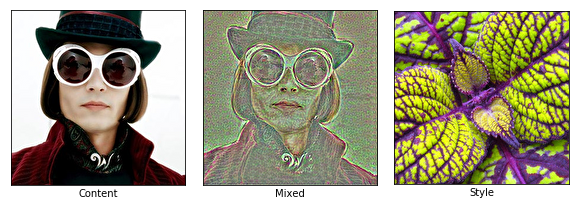

images/outputs_StyleTransfer/Mixed_Iteration19.jpg



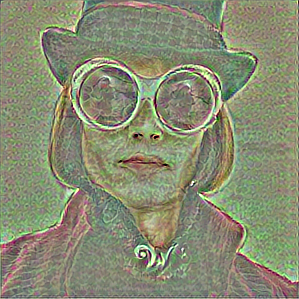

Wall time: 4min 7s


In [23]:
%%time
#print(np.float32(weightContent))
#weightContent=np.float32(weightContent)
#print(np.float32(weightStyle))
#weightStyle=np.float32(weightStyle)
#print(np.float32(weightDenoise))
#weightDenoise=np.float32(weightDenoise)

#Validation the user input for blank and converting each input to the required input datatype.
#If user input is blank then assigning a default value to the input variable passed as input to the style_transfer function.

if (weightContent!=''):
    weightContent=np.float32(weightContent)
    print('Weight Content',weightContent)
else:
    weightContent=1.5
    print('Weight Content',weightContent)

if (weightStyle!=''):
    weightStyle=np.float32(weightStyle)
    print('Weight Style', weightStyle)
else:
    weightStyle=10.0
    print('Weight Style:',weightStyle)

if (weightDenoise!=''):
    weightDenoise=np.float32(weightDenoise)
    print('Weight Denoise', weightDenoise)
else:
    weightDenoise=0.3
    print('Weight Denoise', weightDenoise)

if (noOfIterations!=''):
    noOfIterations=np.int(noOfIterations)
    print('No of Iterations:',noOfIterations)
else:
    noOfIterations=120
    print('Number of Iterations:',noOfIterations)
    
if (stepSize!=''):
    stepSize=np.float32(stepSize)
    print('Step Size:',stepSize)
else:
    stepSize=10.0
    print('Step Size:',stepSize)

#img = style_transfer(content_image=content_image,
#                     style_image=style_image,
#                    content_layer_ids=content_layer_ids,
#                     style_layer_ids=style_layer_ids,
#                     weight_content=1.5,
#                     weight_style=10.0,
#                     weight_denoise=0.3,
#                     num_iterations=60,
#                     step_size=10.0)

img = style_transfer(content_image=content_image,
                     style_image=style_image,
                      content_layer_ids=content_layer_ids,
                      style_layer_ids=style_layer_ids,
                      weight_content=weightContent,
                      weight_style=weightStyle,
                      weight_denoise=weightDenoise,
                      num_iterations=noOfIterations,
                      step_size=stepSize)

### Printing Output Image:
Function to print output image with name as Mixed.jpg

In [ ]:
# Function for printing mixed output image
filename='images/outputs_StyleTransfer/Mixed.jpg'
save_image(img, filename)

## Conclusion

This tutorial showed the basic idea of using neural networks for combining the content and style of two images. The results were unfortunately not as pretty as some of the systems that are commercially available, such as [DeepArt](http://www.deepart.io) which was developed by some of the pioneers in these techniques. The reason is unclear. Perhaps we simply need more computational power so we can perform more optimization iterations with smaller step-sizes and for higher-resolution images. Or perhaps we need to use a more sophisticated optimization method. The exercises below give suggestions that may improve the quality and you are encouraged to try them.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.